<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Описание проекта:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


**Описание данных:**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План работы**

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Установим недостающие библиотеки

In [2]:
pip install LightGBM

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install CatBoost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install hyperopt

     |████████████████████████████████| 1.6 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 74.8 MB/s eta 0:00:01
     |████████████████████████████████| 840 kB 60.3 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492026 sha256=d359cc3576aeb4bb0e43b673f0a3cd6749e061267610b35d3e5b5efcf8d6ada0
  Stored in directory: /home/jovyan/.cache/pip/wheels/bf/5d/6a/2e53874f7ec4e2bede522385439531fafec8fafe005b5c3d1b
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [5]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, tpe, Trials
import warnings
warnings.filterwarnings('ignore')

In [6]:
# сохраним датасет в переменной taxi
try:
    taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [7]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
# ресемплируем данные по 1 часу

taxi = taxi.resample('1H').sum()

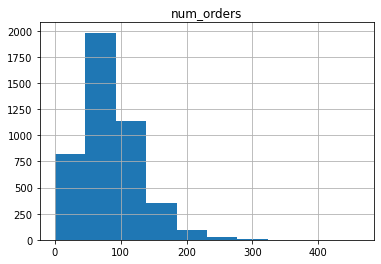

In [10]:
taxi.hist() # посмотрим распределение заказов
None

Выбросов явных нет, пропусков нет, все хорошо с данными. Можно приступать к анализу.

## Анализ

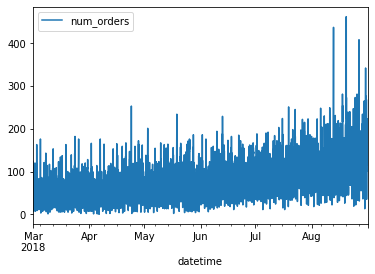

In [11]:
taxi.plot() # нарисуем график заказов
None

Ниче не понятно

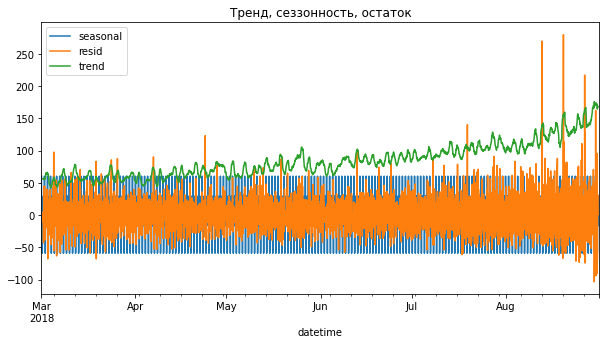

In [12]:
# разложим временной ряд на компоненты
dec = seasonal_decompose(taxi)

# рисуем график
plt.figure(figsize=(10, 5))
dec.seasonal.plot()
dec.resid.plot()
dec.trend.plot()
plt.title('Тренд, сеззонность, остаток')
plt.legend()
None

Тренд плавно идет вверх, шум постепенно увеличивается, сезонность непонятно.

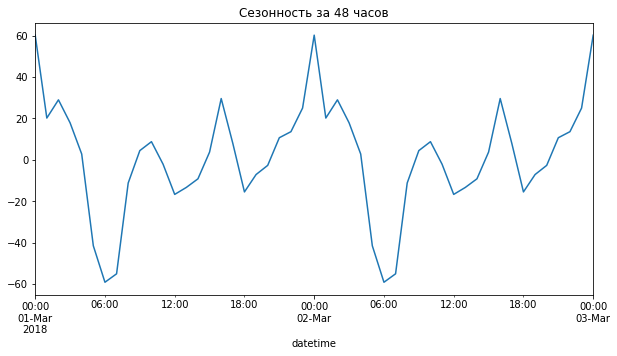

In [13]:
# Нарисуем график сеззоности за 48 часов

plt.figure(figsize=(10, 5))
dec.seasonal.head(49).plot()
plt.title('Сезонность за 48 часов')
None

Сезонность прослеживается ежедневная. В 6 утра уровень заказов минимальный, в полночь максимальный.

**Выводы:**
* количество заказов растет(тренд);
* сезонность ежедневная;
* разброс увеличивается.

## Обучение

In [14]:
# функция создания признаков

def make_features(df, max_lag, rolling_mean_size):
    
    # календарные фичи
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    
    # отстающие значения
    for i in range(1, max_lag+1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)
        
    # rolling_mean
    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()
        
    return df

Эмпирическим путем было выявлено что лучшие значения RMSE получаются при значении rolling_mean_size около 7 и max_lag = 24 и более(при больших значениях качество увеличивается но незначительно).

In [15]:
# создаем признаки

data = make_features(taxi.copy(), 24, 7)
data = data.dropna()
display(data.head())
data.info()

,num_orders,hour,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,2,3,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,65.714286
2018-03-02 01:00:00,120,1,2,3,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.285714
2018-03-02 02:00:00,75,2,2,3,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,79.000000
2018-03-02 03:00:00,64,3,2,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,83.285714
2018-03-02 04:00:00,20,4,2,3,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,83.714286


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   hour          4392 non-null   int64  
 2   day           4392 non-null   int64  
 3   month         4392 non-null   int64  
 4   lag_1         4392 non-null   float64
 5   lag_2         4392 non-null   float64
 6   lag_3         4392 non-null   float64
 7   lag_4         4392 non-null   float64
 8   lag_5         4392 non-null   float64
 9   lag_6         4392 non-null   float64
 10  lag_7         4392 non-null   float64
 11  lag_8         4392 non-null   float64
 12  lag_9         4392 non-null   float64
 13  lag_10        4392 non-null   float64
 14  lag_11        4392 non-null   float64
 15  lag_12        4392 non-null   float64
 16  lag_13        4392 non-null   float64
 17  lag_14        4392 non-null

In [16]:
# cплитуем выборку
data_train, data_test = train_test_split(data, shuffle=False, test_size=0.1)

# целевой признак
y_train = data_train['num_orders']
y_test = data_test['num_orders']

# остальные фичи
x_train = data_train.drop('num_orders', axis=1)
x_test = data_test.drop('num_orders', axis=1)

In [17]:
# Линейная регрессия
res = 0
for train_index, val_index in TimeSeriesSplit(n_splits=3).split(x_train):
    model = LinearRegression()
    model.fit(x_train.iloc[train_index], y_train.iloc[train_index])
    pred = model.predict(x_train.iloc[val_index])
    res += mean_squared_error(y_train.iloc[val_index], pred, squared=False)
    result = res / 3
print('RMSE:', result)

RMSE: 27.55725933913607


In [18]:
# Дерево решений
best_result = 100
best_depth = 0
for depth in range(1, 16):
    res = 0
    model = DecisionTreeRegressor(max_depth=depth, random_state=123)
    for train_index, val_index in TimeSeriesSplit(n_splits=3).split(x_train):
        model.fit(x_train.iloc[train_index], y_train.iloc[train_index])
        pred = model.predict(x_train.iloc[val_index])
        res += mean_squared_error(y_train.iloc[val_index], pred, squared=False)
        result = res / 3
#         print('RMSE:', result)
#         print('max_depth:', depth)
#         print('-----------------------------')
        if result < best_result:
            best_result, best_depth = result, depth
print(f'Лучший результат: max_depth={best_depth}, RMSE={best_result}')

Лучший результат: max_depth=2, RMSE=10.010256257625676


In [19]:
# пространство гиперпараметров для Random Forest

search_space_rf = {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 260, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int))    
}

In [20]:
# пространство гиперпараметров для CatBoost

search_space_ctb = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.51, 0.05)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 260, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 10, 1, dtype=int))
    
}

In [21]:
# # зафиксируем массивы возможных значений в отдельные переменные для более удобного вывода результата
_learning_rate = np.arange(0.05, 0.51, 0.05)
_n_estimators = np.arange(100, 260, 10, dtype=int)
_max_depth = np.arange(5, 16, 1, dtype=int)

In [22]:
def rf_obj(args):
    rf = RandomForestRegressor(**args, random_state=123)
    r = []
    for train_index, val_index in TimeSeriesSplit(n_splits=3).split(x_train):
        rf.fit(x_train.iloc[train_index], y_train.iloc[train_index])
        pred = rf.predict(x_train.iloc[val_index])
        res = mean_squared_error(y_train.iloc[val_index], pred, squared=False)
        r.append(res)
    score = sum(r) / len(r)
    print('Hyperparameters : {}'.format(args))
    print('RMSE : {}\n'.format(score))    
    return score

In [23]:
def ctb_obj(args):
    ctb = CatBoostRegressor(**args, silent=True, random_state=123)
    r = []
    for train_index, val_index in TimeSeriesSplit(n_splits=3).split(x_train):
        ctb.fit(x_train.iloc[train_index], y_train.iloc[train_index])
        pred = ctb.predict(x_train.iloc[val_index])
        res = mean_squared_error(y_train.iloc[val_index], pred, squared=False)
        r.append(res)
    score = sum(r) / len(r)
    print('Hyperparameters : {}'.format(args))
    print('RMSE : {}\n'.format(score))    
    return score

In [24]:
# обучаем Random Forest

# print('RandomForest')
# rf_trials = Trials()
# rf_best_res = fmin(rf_obj, space=search_space_rf, algo=tpe.suggest, trials=rf_trials, max_evals=50)

# print('-------------------------------------')        
# print('Итоговые результаты:')
# print('Значение RMSE:', rf_trials.average_best_error().round(2))
# print('Лучшее значение n_estimators', _n_estimators[rf_best_res['n_estimators']])
# print('Лучшее значение max_depth', _max_depth[rf_best_res['max_depth']])

In [25]:
# -------------------------------------
# Итоговые результаты:
# Значение RMSE: 26.85
# Лучшее значение n_estimators 160
# Лучшее значение max_depth 15

In [26]:
# обучаем CatBoost

# print('CatBoost')
# ctb_trials = Trials()
# ctb_best_res = fmin(ctb_obj, space=search_space_ctb, algo=tpe.suggest, trials=ctb_trials, max_evals=50)

# print('-------------------------------------')        
# print('Итоговые результаты:')
# print('Значение RMSE:', ctb_trials.average_best_error().round(2))
# print('Лучшее значение learning_rate', _learning_rate[ctb_best_res['learning_rate']])
# print('Лучшее значение max_depth', _max_depth[ctb_best_res['max_depth']])
# print('Лучшее значение n_estimators', _n_estimators[ctb_best_res['n_estimators']])

In [27]:
# Итоговые результаты:
# Значение RMSE: 25.99
# Лучшее значение learning_rate 0.1
# Лучшее значение max_depth 6
# Лучшее значение n_estimators 250

**Вывод:**
* cоздана функция создания признаков `make_features`;
* oпытным путем выявлены оптимальные параметры `max_lag` и `rolling_mean_size` - 24 и 7;
* обучено 4 модели: *линейная регрессия, дерево решений, случайный лес, CatBoost*. 
* подобраны оптимальные гиперпараметры путем минимизации функции потерь на кросс-валидации с помощью hyperopt.

## Тестирование

In [28]:
# инициализируем модели с лучшими гиперпараметрами
lr = LinearRegression()
dt = DecisionTreeRegressor(max_depth=2, random_state=123)
rf = RandomForestRegressor(max_depth=15, n_estimators=160, random_state=123)
ct = CatBoostRegressor(max_depth=6, n_estimators=250, learning_rate=0.1, silent=True, random_state=123)

names = ['LinReg', 'DecissionTree', 'RandomForest', 'CatBoost']
models = [lr, dt, rf, ct]

In [29]:
# тестируем модели
print('RMSE')
for name, model in zip(names, models):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print(f'{name}: {rmse}')

RMSE
LinReg: 45.88551482175842
DecissionTree: 62.72580696669904
RandomForest: 41.89677507886101
CatBoost: 40.742022111004324


### Проверка на адекватность

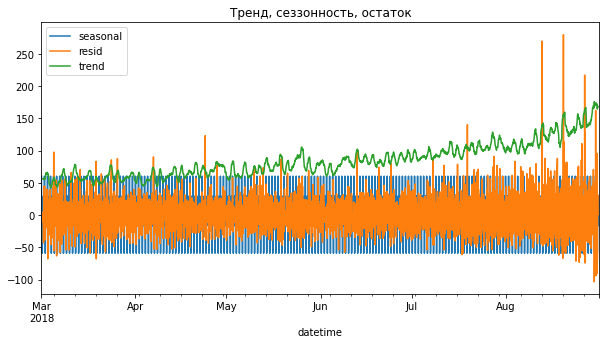

In [30]:
# еще раз взглянем на график

plt.figure(figsize=(10, 5))
dec.seasonal.plot()
dec.resid.plot()
dec.trend.plot()
plt.title('Тренд, сеззонность, остаток')
plt.legend()
None

Сезонность, вещь цикличная ее можно предсказать зная час, тренд можно аппроксимировать линейно или полиномом. Шум вещь случайная, ее предсказать нельзя.

In [31]:
dcmps = seasonal_decompose(data_train['num_orders']) # декомпозируем обучающую выборку

# создадим массивы х и у
values_y = dcmps.trend.dropna().values
values_x = np.array(range(len(dcmps.trend.dropna().values)))

In [32]:
# defining objective functions 
def mapping1(values_x, a, b): 
    return a * values_x + b  # линейная функция
 
def mapping2(values_x, a, b, c): 
    return a * values_x**2 + b * values_x + c  # квадратичная функция

In [33]:
# подбираем оптимальные коэффициенты

args, _ = curve_fit(mapping1, values_x, values_y) 
a, b = args[0], args[1]
y_fit1 = a * values_x + b
 
args, _  = curve_fit(mapping2, values_x, values_y) 
a, b, c = args[0], args[1], args[2] 
y_fit2 = a * values_x**2 + b * values_x + c 

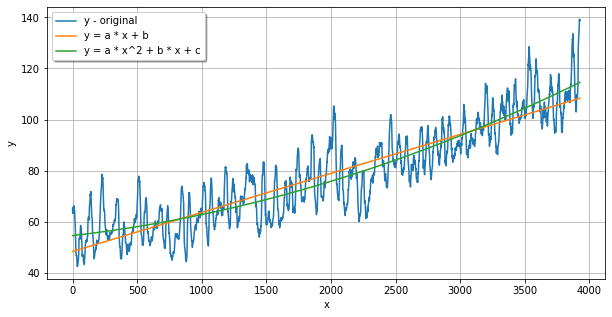

In [34]:
# plotting the graph 
plt.figure(figsize=(10, 5))
plt.plot(values_x, values_y, label="y - original") 
plt.plot(values_x, y_fit1, label="y = a * x + b") 
plt.plot(values_x, y_fit2, label="y = a * x^2 + b * x + c") 
plt.xlabel('x') 
plt.ylabel('y') 
plt.legend(loc = 'best', fancybox = True, shadow = True) 
plt.grid(True) 
plt.show() 

Будем использовать квадратичный полином

In [35]:
data_test['num_orders']

datetime
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
2018-08-13 20:00:00     82
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 440, dtype: int64

In [36]:
# Делаем предсказания

values_x1 = np.array(range(4416)) 
y_fit = a * values_x1**2 + b * values_x1 + c # продолжаем "параболу" до сегодняшнего дня

In [37]:
# рисуем таблцицу

base = pd.DataFrame(y_fit, index=taxi.index)
base.columns = ['trend']
base['seasonal'] = dec.seasonal

# предсказание базлайна(значение тренда + значение сезонности)
base['result'] = base['trend'] + base['seasonal'] 
base

,trend,seasonal,result
datetime,,,
2018-03-01 00:00:00,54.537069,60.248112,114.785181
2018-03-01 01:00:00,54.542883,20.177074,74.719957
2018-03-01 02:00:00,54.548702,28.982743,83.531446
2018-03-01 03:00:00,54.554526,17.885407,72.439934
2018-03-01 04:00:00,54.560355,2.791145,57.351500
...,...,...,...
2018-08-31 19:00:00,127.064961,-7.124270,119.940691
2018-08-31 20:00:00,127.092036,-2.696560,124.395476
2018-08-31 21:00:00,127.119117,10.670243,137.789360


In [38]:
# возьмем последние 442 значения для сравнения с тестовой выборкой

pred_base = base['result'].tail(440)
pred_base

datetime
2018-08-13 16:00:00    145.348308
2018-08-13 17:00:00    123.689202
2018-08-13 18:00:00    100.266212
2018-08-13 19:00:00    108.694889
2018-08-13 20:00:00    113.147591
                          ...    
2018-08-31 19:00:00    119.940691
2018-08-31 20:00:00    124.395476
2018-08-31 21:00:00    137.789360
2018-08-31 22:00:00    140.743016
2018-08-31 23:00:00    152.173795
Freq: H, Name: result, Length: 440, dtype: float64

In [39]:
# Считаем метрику RMSE

rmse_base = mean_squared_error(y_test, pred_base, squared=False)
print('RMSE базовой модели:', rmse_base)

RMSE базовой модели: 46.83617757226775


Теперь более понятно почему модели на тесте должны показать RMSE не более 48 :D

LinReg: 45.88551482175842
DecissionTree: 62.72580696669904
RandomForest: 41.89677507886101
CatBoost: 40.742022111004324

**Вывод:** 

Все модели, кроме решающего дерева прошли проверку на вменяемость, лучший результат показала модель CatBoost с RMSE = 41

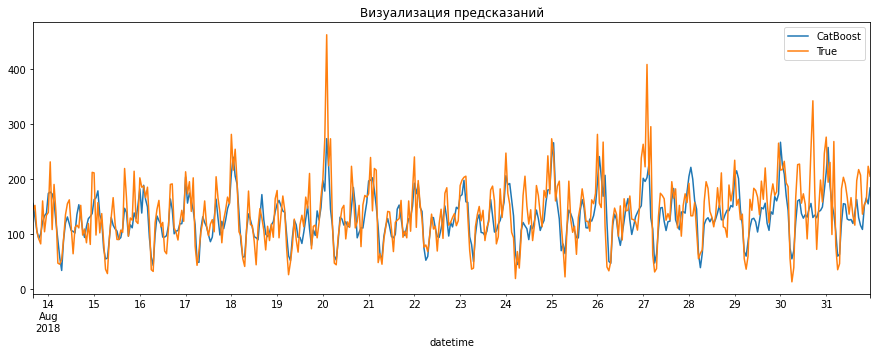

In [63]:
# рисуем результаты

result = pd.DataFrame({'CatBoost': pred, 'True': y_test}, index=y_test.index)
result.plot(figsize=(15, 5))
plt.title('Визуализация предсказаний')
None

## Вывод

Вывод по исследованию прогнозирования заказов такси:

1. Предобработка данных:
- Данные не требовали очистки, пропусков и выбросов не обнаружено
- Выполнено ресемплирование данных по часам 

2. Анализ данных:
- Выявлен положительный тренд количества заказов 
- Обнаружена ежедневная сезонность - минимум заказов в 6 утра, максимум в полночь
- Выявлено увеличение разброса данных со временем

3. Обучение моделей:
- Реализована функция генерации признаков make_features
- Опытным путем определены оптимальные параметры: max_lag = 24, rolling_mean_size = 7
- Обучены 4 модели: линейная регрессия, дерево решений, случайный лес и CatBoost
- Подобраны оптимальные гиперпараметры с помощью cross-validation и hyperopt

4. Тестирование:
- Лучший результат показала модель CatBoost, RMSE = 40.74
- Все модели, кроме дерева решений, прошли проверку на адекватность 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48